In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import ripleyK as rk
import spherical_stats as ss
from mpl_toolkits.mplot3d import Axes3D
from tensorflow_probability import distributions as tfd

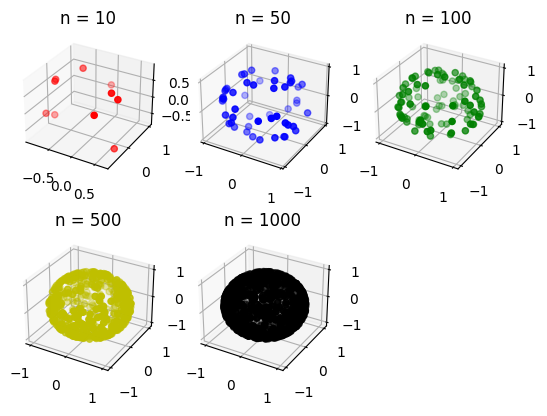

In [2]:
# Source How to generate equidistributed points on the surface of a sphere -- https://www.cmu.edu/biolphys/deserno/pdf/sphere_equi.pdf
# Randomly generate points on a sphere
# Radius = 1
# Center = (0,0,0)

def samples(n):
    # Generating z coordinates with radius = 1
    z = np.random.uniform(-1,1,n)

    # Generating azimuthal angles
    phi = np.random.uniform(0,2*math.pi,n)

    # Generating x and y coordinates
    x = np.sqrt(1-z**2)*np.cos(phi)
    y = np.sqrt(1-z**2)*np.sin(phi)
    samples = np.array([x,y,z]).T
    return samples

# Generating samples with n = 10, 50, 100, 500, 1000
samples_uniform10 = samples(10)
samples_uniform50 = samples(50)
samples_uniform100 = samples(100)
samples_uniform500 = samples(500)
samples_uniform1000 = samples(1000)

# Plotting the points
""" fig1, fig2, fig3, fig4, fig5 = plt.figure(), plt.figure(), plt.figure(), plt.figure(), plt.figure()
ax1 = fig1.add_subplot(111, projection='3d')
ax2 = fig2.add_subplot(111, projection='3d')
ax3 = fig3.add_subplot(111, projection='3d')
ax4 = fig4.add_subplot(111, projection='3d')
ax5 = fig5.add_subplot(111, projection='3d')
ax1.scatter(samples_uniform10[:,0],samples_uniform10[:,1],samples_uniform10[:,2], c='r', marker='o')
ax2.scatter(samples_uniform50[:,0],samples_uniform50[:,1],samples_uniform50[:,2], c='b', marker='o')
ax3.scatter(samples_uniform100[:,0],samples_uniform100[:,1],samples_uniform100[:,2], c='g', marker='o')
ax4.scatter(samples_uniform500[:,0],samples_uniform500[:,1],samples_uniform500[:,2], c='y', marker='o')
ax5.scatter(samples_uniform1000[:,0],samples_uniform1000[:,1],samples_uniform1000[:,2], c='k', marker='o') """

# Plotting the points in a single figure
fig = plt.figure()
ax1 = fig.add_subplot(231, projection='3d')
ax2 = fig.add_subplot(232, projection='3d')
ax3 = fig.add_subplot(233, projection='3d')
ax4 = fig.add_subplot(234, projection='3d')
ax5 = fig.add_subplot(235, projection='3d')
ax1.set_title('n = 10')
ax1.scatter(samples_uniform10[:,0],samples_uniform10[:,1],samples_uniform10[:,2], c='r', marker='o')
ax2.set_title('n = 50')
ax2.scatter(samples_uniform50[:,0],samples_uniform50[:,1],samples_uniform50[:,2], c='b', marker='o')
ax3.set_title('n = 100')
ax3.scatter(samples_uniform100[:,0],samples_uniform100[:,1],samples_uniform100[:,2], c='g', marker='o')
ax4.set_title('n = 500')
ax4.scatter(samples_uniform500[:,0],samples_uniform500[:,1],samples_uniform500[:,2], c='y', marker='o')
ax5.set_title('n = 1000')
ax5.scatter(samples_uniform1000[:,0],samples_uniform1000[:,1],samples_uniform1000[:,2], c='k', marker='o')
plt.show()

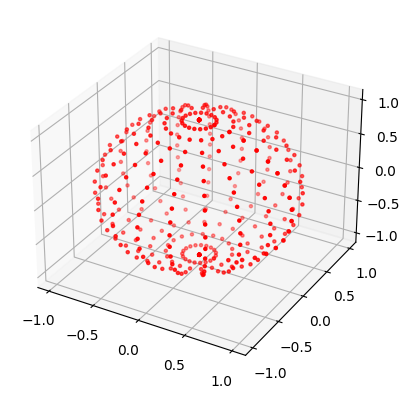

In [3]:
# Create samples using mgrid
n = 20

def mgrid_samples(n):
    u, v = np.mgrid[0:2*np.pi:n*1j, 0:np.pi:n*1j]

    x_mgrid = np.cos(u)*np.sin(v)
    y_mgrid = np.sin(u)*np.sin(v)
    z_mgrid = np.cos(v)

    samples = np.array([x_mgrid,y_mgrid,z_mgrid]).T.reshape(-1,3)
    return samples

x_mgrid, y_mgrid, z_mgrid = mgrid_samples(n).T
# plot the points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_mgrid, y_mgrid, z_mgrid, s=5, color="r")

plt.show()

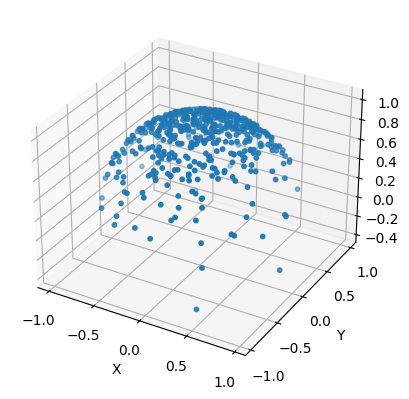

In [4]:
# define parameters of von Mises-Fisher distribution
mu = [0, 0, 1.]
kappa = 5

def vmf_samples(n, mu, kappa):
    vmf = tfd.VonMisesFisher(mu, kappa)

    # normalize samples to unit sphere
    samples_vmf = vmf.sample(n)
    samples_vmf = samples_vmf.numpy()
    samples_vmf = samples_vmf / np.linalg.norm(samples_vmf, axis=1, keepdims=True)

    return samples_vmf

# generate samples
samples_vmf = vmf_samples(500, mu, kappa)

# create 3D plot of samples on sphere
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(samples_vmf[:,0], samples_vmf[:,1], samples_vmf[:,2], s=10)

# set axis limits and labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# show plot
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

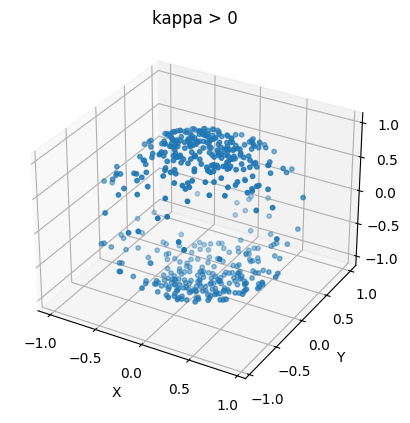

In [5]:
# sample with watson distribution
mu = [0, 0, 1.]
kappa = 5

def watson_samples_g0(n, mu, kappa):
    # create watson distribution
    rv_watson = ss.Watson(mu, kappa)

    # sample from watson distribution
    samples_watson = rv_watson.rvs(n)

    # normalize samples to unit sphere
    samples_watson_g0 = samples_watson / np.linalg.norm(samples_watson, axis=1, keepdims=True)

    return samples_watson_g0

# generate samples
samples_watson_g0 = watson_samples_g0(500, mu, kappa)

# create 3D plot of samples on sphere
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(samples_watson_g0[:,0], samples_watson_g0[:,1], samples_watson_g0[:,2], s=10)

# set axis limits and labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('kappa > 0')

# show plot
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

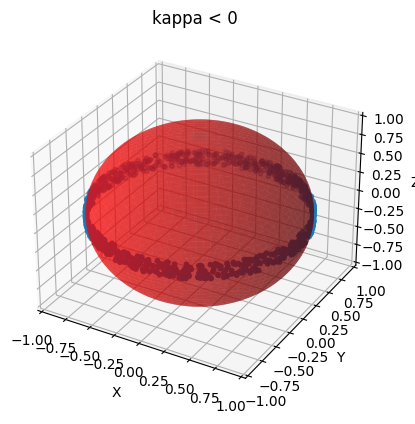

In [6]:
# Sample watson distribution with kappa < 0
def watson_samples_l0(r, ebs, n):
    # Generating uniform azimuthal angles
    azimuth = np.random.uniform(0,2*math.pi,n)

    # Generating uniform polar angles aorund equator
    polar = np.random.uniform(math.pi/2-ebs,math.pi/2+ebs,n)
    # phi = np.random.uniform(math.pi/2,math.pi/2,n)

    # Generating x,y,z coordinates
    x = r*np.sin(polar)*np.cos(azimuth)
    y = r*np.sin(polar)*np.sin(azimuth)
    z = r*np.cos(polar)
    samples = np.array([x,y,z]).T
    return samples

# Generating samples 
samples_watson_l0 = watson_samples_l0(1, 0.1, 1000)
# samples_watson_l0 = samples_watson_l0 / np.linalg.norm(samples_watson_l0, axis=1, keepdims=True)

# create 3D plot of samples on sphere
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(samples_watson_l0[:,0], samples_watson_l0[:,1], samples_watson_l0[:,2], s=10)

# Create a sphere
r = 1
u, v = np.mgrid[0:2*np.pi:100j, 0:np.pi:50j]
x = r*np.cos(u)*np.sin(v)
y = r*np.sin(u)*np.sin(v)
z = r*np.cos(v)

# Add surface plot of sphere
ax.plot_surface(x, y, z, color='r', alpha=0.5, label='Sphere')

# set axis limits and labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)
ax.set_title('kappa < 0')

# show plot
plt.show


(500, 3)


<function matplotlib.pyplot.show(close=None, block=None)>

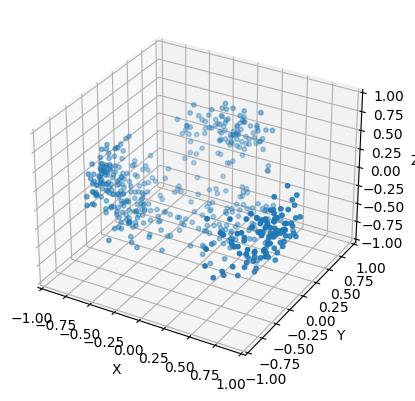

In [7]:
# Generating samples 
mu = samples(5)

# sample multiple von Mises-Fisher distributions with n points each
def mixture_dist_sphere(mu, kappa, n):
    samples = []
    for i in range(len(mu)):
        vmf = tfd.VonMisesFisher(mu[i], kappa)

        # normalize samples to unit sphere
        samples_vmf = vmf.sample(n)
        samples_vmf = samples_vmf.numpy()
        samples_vmf = samples_vmf / np.linalg.norm(samples_vmf, axis=1, keepdims=True)
        if i == 0:
            samples = samples_vmf
        else:
            samples = np.concatenate((samples, samples_vmf), axis=0)
        
    return np.array(samples)

samples_mix = mixture_dist_sphere(mu, 20, 100)
print(samples_mix.shape)

# create 3D plot of samples on sphere
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(samples_mix[:,0], samples_mix[:,1], samples_mix[:,2], s=10)

# set axis limits and labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)

# show plot
plt.show

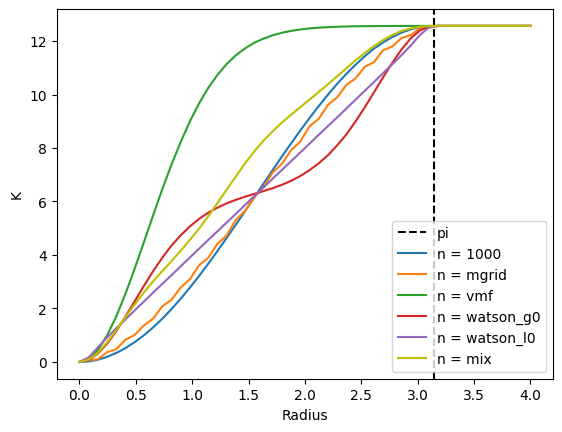

In [8]:
radii = np.linspace(0, 4, 50)

kt_uniform10 = rk.ripleyK(1, samples_uniform10, radii)
kt_uniform50 = rk.ripleyK(1, samples_uniform50, radii)
kt_uniform100 = rk.ripleyK(1, samples_uniform100, radii)
kt_uniform500 = rk.ripleyK(1, samples_uniform500, radii)
kt_uniform1000 = rk.ripleyK(1, samples_uniform1000, radii)

x = np.ravel(x_mgrid)
y = np.ravel(y_mgrid)
z = np.ravel(z_mgrid)
samples_mgrid = np.array([x,y,z]).T
kt_mgrid = rk.ripleyK(1, samples_mgrid, radii)

kt_vmf = rk.ripleyK(1, samples_vmf, radii)
kt_watson_g0 = rk.ripleyK(1, samples_watson_g0, radii)
kt_watson_l0 = rk.ripleyK(1, samples_watson_l0, radii)
kt_mix = rk.ripleyK(1, samples_mix, radii)


plt.axvline(x=math.pi, color='black', linestyle='--', label="pi")
plt.plot(radii, kt_uniform1000, label='n = 1000')
plt.plot(radii, kt_mgrid, label='n = mgrid')
plt.plot(radii, kt_vmf, label='n = vmf')
plt.plot(radii, kt_watson_g0, label='n = watson_g0')
plt.plot(radii, kt_watson_l0, label='n = watson_l0')
plt.plot(radii, kt_mix, label='n = mix', color='y')
plt.xlabel('Radius')
plt.ylabel('K')
plt.legend()
plt.savefig('ripleyK_sphere.png')
plt.show()